In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

import i3d
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7278234496536855299
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 140443648
locality {
  bus_id: 1
}
incarnation: 8869463432397407824
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


In [5]:
"""
Build RBG Graph
"""
_IMAGE_SIZE = 224
_NUM_CLASSES = 400

_SAMPLE_VIDEO_FRAMES = 25
_SAMPLE_PATHS = {
    'rgb': 'data/v_CricketShot_g04_c01_rgb.npy',
    'flow': 'data/v_CricketShot_g04_c01_flow.npy',
}

_CHECKPOINT_PATHS = {
    'rgb': 'data/checkpoints/rgb_scratch/model.ckpt',
    'flow': 'data/checkpoints/flow_scratch/model.ckpt',
    'rgb_imagenet': 'data/checkpoints/rgb_imagenet/model.ckpt',
    'flow_imagenet': 'data/checkpoints/flow_imagenet/model.ckpt',
}

_LABEL_MAP_PATH = 'data/label_map.txt'

#FLAGS = tf.flags.FLAGS

#tf.flags.DEFINE_string('eval_type', 'joint', 'rgb, flow, or joint')
#tf.flags.DEFINE_boolean('imagenet_pretrained', True, '')
tf.reset_default_graph()
tf.logging.set_verbosity(tf.logging.INFO)
#eval_type = FLAGS.eval_type
#imagenet_pretrained = FLAGS.imagenet_pretrained
kinetics_classes = [x.strip() for x in open(_LABEL_MAP_PATH)]
rgb_input = tf.placeholder(tf.float32, shape=(1, None, _IMAGE_SIZE, _IMAGE_SIZE, 3))
with tf.variable_scope('RGB'):
        rgb_model = i3d.InceptionI3d(_NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
        rgb_logits, _ = rgb_model(rgb_input, is_training=False, dropout_keep_prob=1.0)
rgb_variable_map = {}
for variable in tf.global_variables():
    if variable.name.split('/')[0] == 'RGB':
        rgb_variable_map[variable.name.replace(':0', '')] = variable
rgb_saver = tf.train.Saver(var_list=rgb_variable_map, reshape=True)
model_logits = rgb_logits
model_predictions = tf.nn.softmax(model_logits)


In [6]:
"""
Run sample prediction with RBG only
"""
eval_type = 'rgb'
imagenet_pretrained = True
print("wiener")
with tf.Session() as sess:
        feed_dict = {}
        if eval_type in ['rgb', 'joint']:
            if imagenet_pretrained:
                print("pretrained")
                rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
            else:
                rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb'])
            tf.logging.info('RGB checkpoint restored')
            rgb_sample = np.load(_SAMPLE_PATHS['rgb'])
            print("RGB size:", rgb_sample.shape)
            tf.logging.info('RGB data loaded, shape=%s', str(rgb_sample.shape))
            feed_dict[rgb_input] = rgb_sample

        if eval_type in ['flow', 'joint']:
            if imagenet_pretrained:
                flow_saver.restore(sess, _CHECKPOINT_PATHS['flow_imagenet'])
            else:
                flow_saver.restore(sess, _CHECKPOINT_PATHS['flow'])
            tf.logging.info('Flow checkpoint restored')
            flow_sample = np.load(_SAMPLE_PATHS['flow'])
            print("flow size:", flow_sample.shape)
            tf.logging.info('Flow data loaded, shape=%s',
                            str(flow_sample.shape))
            feed_dict[flow_input] = flow_sample
        out_logits, out_predictions = sess.run(
            [model_logits, model_predictions],
            feed_dict=feed_dict)
        out_logits = out_logits[0]
        out_predictions = out_predictions[0]
        sorted_indices = np.argsort(out_predictions)[::-1]

        print('Norm of logits: %f' % np.linalg.norm(out_logits))
        print('\nTop classes and probabilities')
        for index in sorted_indices[:20]:
            print(out_predictions[index], out_logits[
                  index], kinetics_classes[index])
        out_logits, out_predictions = sess.run(
            [model_logits, model_predictions],
            feed_dict=feed_dict)
        out_logits = out_logits[0]
        out_predictions = out_predictions[0]
        sorted_indices = np.argsort(out_predictions)[::-1]

        print('Norm of logits: %f' % np.linalg.norm(out_logits))
        print('\nTop classes and probabilities')
        for index in sorted_indices[:20]:
            print(out_predictions[index], out_logits[
                  index], kinetics_classes[index])

wiener
pretrained
INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
INFO:tensorflow:RGB checkpoint restored
RGB size: (1, 79, 224, 224, 3)
INFO:tensorflow:RGB data loaded, shape=(1, 79, 224, 224, 3)
Norm of logits: 87.108879

Top classes and probabilities
0.99999666 25.856651 playing cricket
1.335341e-06 12.330331 playing kickball
4.5531024e-07 11.254368 catching or throwing baseball
3.14341e-07 10.883867 shooting goal (soccer)
1.9243211e-07 10.393132 catching or throwing softball
1.3096448e-07 10.008315 throwing discus
1.0681766e-07 9.804511 javelin throw
9.446406e-08 9.681608 golf putting
7.8428855e-08 9.495581 jogging
7.801721e-08 9.490317 hitting baseball
6.608454e-08 9.324324 triple jump
3.487828e-08 8.685253 hurling (sport)
2.996551e-08 8.533437 skateboarding
2.1083729e-08 8.1818905 hurdling
2.007925e-08 8.133076 playing tennis
1.8453855e-08 8.048662 breakdancing
1.7050727e-08 7.9695816 hammer throw
1.7004478e-08 7.9668646 shot put
1.4611323e-08 7

In [11]:
from scipy.ndimage.filters import gaussian_filter1d
def blur_image(X, sigma=1):
    start = time.time()
    X = gaussian_filter1d(X, sigma, axis=2)
    X = gaussian_filter1d(X, sigma, axis=3)
    print("Blur time", time.time()-start)
    return X

In [24]:
def create_class_visualization(sess, target_y, logits, rgb_input, num_frames, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    l2_reg = kwargs.pop('l2_reg', 1e-4)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)

    X = np.random.rand(num_frames, 224, 224, 3)
    X = X[None]
    #X = preprocess_image(X)[None]
    
    ########################################################################
    # TODO: Compute the loss and the gradient of the loss with respect to  #
    # the input image, model.image. We compute these outside the loop so   #
    # that we don't have to recompute the gradient graph at each iteration #
    #                                                                      #
    # Note: loss and grad should be TensorFlow Tensors, not numpy arrays!  #
    #                                                                      #
    # The loss is the score for the target label, target_y. You should     #
    # use model.classifier to get the scores, and tf.gradients to compute  #
    # gradients. Don't forget the (subtracted) L2 regularization term!     #
    ########################################################################
    # logits command
    # loss = model.classifier[0, target_y] # scalar loss
    loss = logits[0, target_y] # scalar loss
    
    # model.image is just input data 
    # self.image = tf.placeholder('float',shape=[None,None,None,3],name='input_image')
    # grad = tf.gradients(loss, model.image) # gradient of loss with respect to model.image, same size as model.image
    # grad = tf.squeeze(grad) - l2_reg*2*model.image
    
    grad = tf.gradients(loss, rgb_input)
    grad = tf.squeeze(grad) - l2_reg*2*rgb_input
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################

    start_time = time.time()
    for t in range(num_iterations):
        
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
        Xi = X.copy()
        X = np.roll(np.roll(X, ox, 1), oy, 2)

        ########################################################################
        # TODO: Use sess to compute the value of the gradient of the score for #
        # class target_y with respect to the pixels of the image, and make a   #
        # gradient step on the image using the learning rate. You should use   #
        # the grad variable you defined above.                                 #
        #                                                                      #
        # Be very careful about the signs of elements in your code.            #
        ########################################################################
        # we want logits for loss, model.classifier are just logits
        # loss = model.classifier[0, target_y] # scalar loss
        loss = logits[0, target_y] # scalar loss

        # model.image is just the data matrix input (a gif in our case)
        # gradient_step = sess.run(grad, feed_dict={model.image:X})
        gradient_step = sess.run(grad, feed_dict={rgb_input:X})
        X += learning_rate * gradient_step
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # Undo the jitter
        X = np.roll(np.roll(X, -ox, 1), -oy, 2)

        # As a regularizer, clip and periodically blur
        #X = np.clip(X, -SQUEEZENET_MEAN/SQUEEZENET_STD, (1.0 - SQUEEZENET_MEAN)/SQUEEZENET_STD)
        if t % blur_every == 0:
            X = blur_image(X, sigma=1)
        print("iteration:", t, time.time()-start_time)
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            #plt.imshow(deprocess_image(X[0]))
            plt.imshow(X[0][0])
            
            if t == num_iterations-1:
                for i in range(1, num_frames):
                    plt.imshow(X[0][1])
                    plt.show()
                    
            #class_name = class_names[target_y]
            
            class_name = "temp"
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()
        
    return X

Tensor("RGB/inception_i3d/Mean:0", shape=(1, 400), dtype=float32)
Tensor("Placeholder:0", shape=(1, ?, 224, 224, 3), dtype=float32)
INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
Blur time 0.0813100337982
iteration: 0 1.5372171402


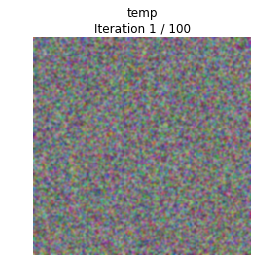

iteration: 1 2.61357021332
iteration: 2 3.54868221283
iteration: 3 4.47806715965
iteration: 4 5.4183549881
iteration: 5 6.33676409721
iteration: 6 7.26209521294
iteration: 7 8.20459699631
iteration: 8 9.13651704788
iteration: 9 10.022124052
Blur time 0.0874681472778
iteration: 10 11.0413730145
iteration: 11 11.9690132141
iteration: 12 12.9128780365
iteration: 13 13.8444480896
iteration: 14 14.7941770554
iteration: 15 15.7223801613
iteration: 16 16.6620411873
iteration: 17 17.5916860104
iteration: 18 18.5108671188
iteration: 19 19.3016541004
Blur time 0.0655741691589
iteration: 20 20.1953830719
iteration: 21 21.0047571659
iteration: 22 21.861716032
iteration: 23 22.7118999958
iteration: 24 23.5702362061


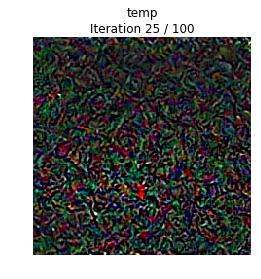

iteration: 25 24.714040041
iteration: 26 25.6112082005
iteration: 27 26.5255041122
iteration: 28 27.4561841488
iteration: 29 28.3912110329
Blur time 0.0590980052948
iteration: 30 29.3979010582
iteration: 31 30.3375680447
iteration: 32 31.301774025
iteration: 33 32.2462379932
iteration: 34 33.1538760662
iteration: 35 34.0657131672
iteration: 36 34.9792141914
iteration: 37 35.9113240242
iteration: 38 36.8720300198
iteration: 39 37.7877399921
Blur time 0.0950498580933
iteration: 40 38.7913150787
iteration: 41 39.7624151707
iteration: 42 40.7067091465
iteration: 43 41.639922142
iteration: 44 42.5963840485
iteration: 45 43.5195951462
iteration: 46 44.45423913
iteration: 47 45.3844621181
iteration: 48 46.2377710342
iteration: 49 47.1780991554


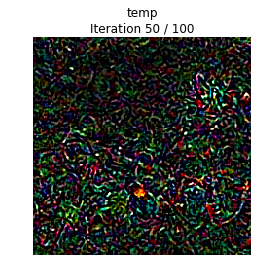

Blur time 0.0704400539398
iteration: 50 48.3211071491
iteration: 51 49.2647440434
iteration: 52 50.1925752163
iteration: 53 51.1323289871
iteration: 54 52.0628662109
iteration: 55 53.0094242096
iteration: 56 53.9498560429
iteration: 57 54.8621411324
iteration: 58 55.7970621586
iteration: 59 56.7327260971
Blur time 0.0928609371185
iteration: 60 57.822974205
iteration: 61 58.7405850887
iteration: 62 59.684030056
iteration: 63 60.6346490383
iteration: 64 61.5716340542
iteration: 65 62.4952452183
iteration: 66 63.4427981377
iteration: 67 64.3935940266
iteration: 68 65.3228712082
iteration: 69 66.2478129864
Blur time 0.0793659687042
iteration: 70 67.2730460167
iteration: 71 68.219312191
iteration: 72 69.0231289864
iteration: 73 69.8502221107
iteration: 74 70.6824650764


iteration: 75 71.5973930359
iteration: 76 72.3971970081
iteration: 77 73.1929709911
iteration: 78 74.004625082
iteration: 79 74.9531471729
Blur time 0.0604350566864
iteration: 80 75.9482111931
iteration: 81 76.8856070042
iteration: 82 77.8052921295
iteration: 83 78.748208046
iteration: 84 79.6593711376
iteration: 85 80.5908010006
iteration: 86 81.5359320641
iteration: 87 82.4619030952
iteration: 88 83.4018712044
iteration: 89 84.34288311
Blur time 0.0948669910431
iteration: 90 85.3754479885
iteration: 91 86.3234422207
iteration: 92 87.2618041039
iteration: 93 88.1900901794
iteration: 94 89.09416008
iteration: 95 90.0467720032
iteration: 96 90.9454801083
iteration: 97 91.8562650681
iteration: 98 92.8010540009
iteration: 99 93.7294380665


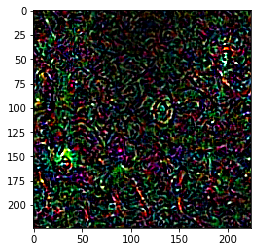

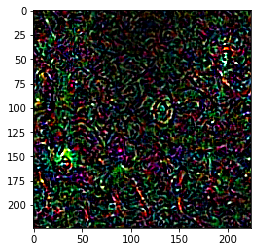

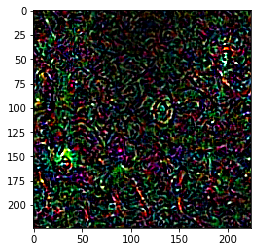

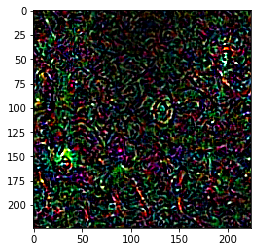

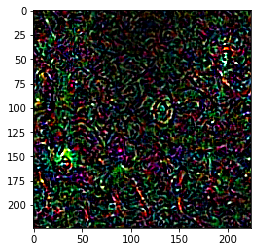

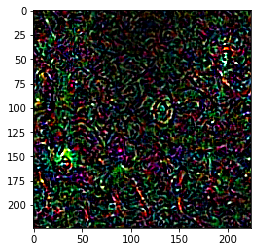

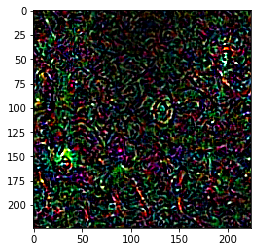

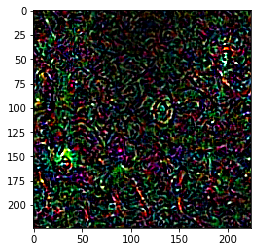

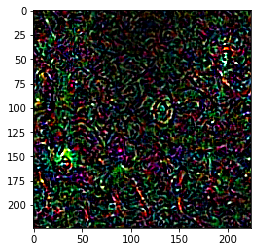

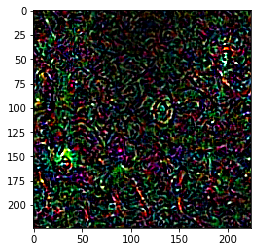

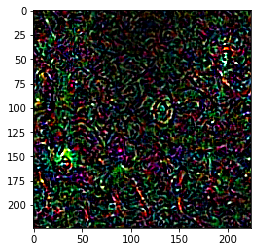

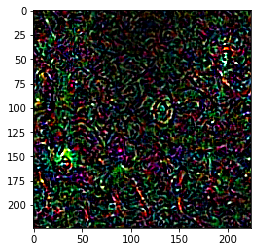

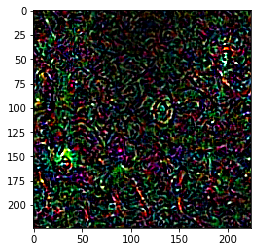

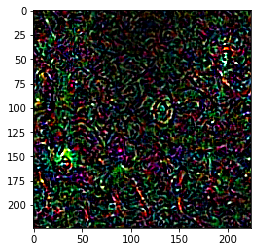

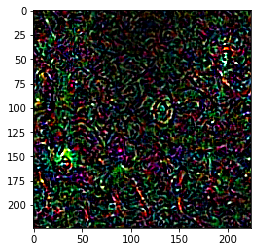

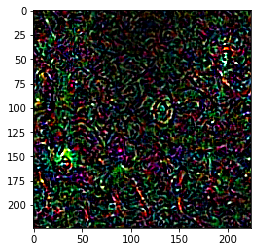

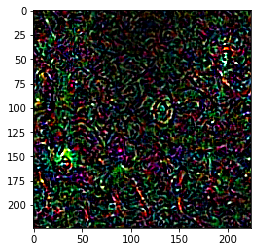

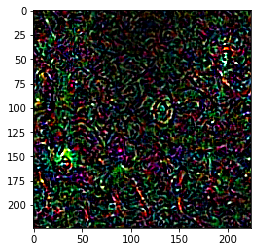

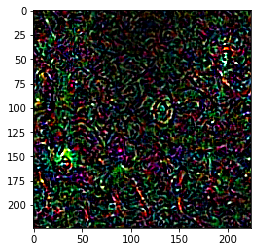

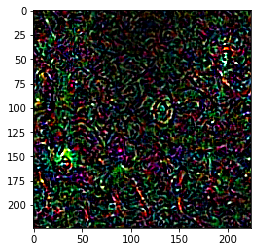

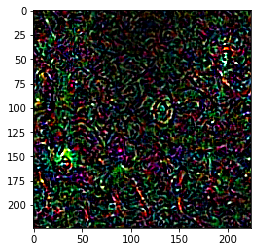

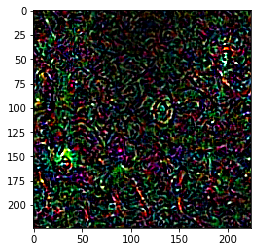

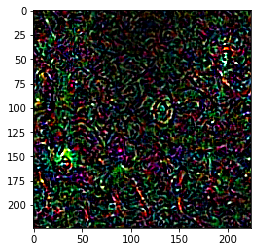

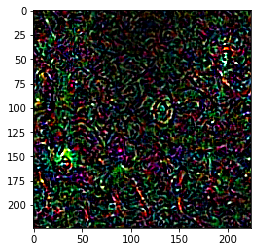

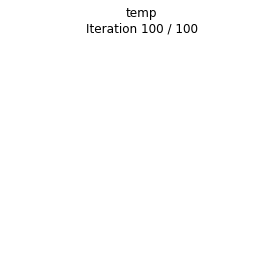

In [25]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print(model_logits)
print(rgb_input)
with tf.device("/gpu:0"):
    with tf.Session() as sess:
        # THIS LINE NEEDS TO BE MOVED
        rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
        create_class_visualization(sess, 6, model_logits, rgb_input, 25, num_iterations=100)